<a href="https://colab.research.google.com/github/yeomyeom/2019_cau_oss_hackathon/blob/master/assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
# https://gigle.tistory.com/121
# math library
import numpy as np

# visualization library
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt

# machine learning library
from sklearn.linear_model import LogisticRegression

# 3d visualization
# from mpl_toolkits.mplot3d import axes3d

# computational time
import time

import math
import pandas as pd

from google.colab import files
files.upload()

Saving data-kmeans.csv to data-kmeans.csv


{'data-kmeans.csv': b'x, y\r\n15,39\r\n15,81\r\n16,6\r\n16,77\r\n17,40\r\n17,76\r\n18,6\r\n18,94\r\n19,3\r\n19,72\r\n19,14\r\n19,99\r\n20,15\r\n20,77\r\n20,13\r\n20,79\r\n21,35\r\n21,66\r\n23,29\r\n23,98\r\n24,35\r\n24,73\r\n25,5\r\n25,73\r\n28,14\r\n28,82\r\n28,32\r\n28,61\r\n29,31\r\n29,87\r\n30,4\r\n30,73\r\n33,4\r\n33,92\r\n33,14\r\n33,81\r\n34,17\r\n34,73\r\n37,26\r\n37,75\r\n38,35\r\n38,92\r\n39,36\r\n39,61\r\n39,28\r\n39,65\r\n40,55\r\n40,47\r\n40,42\r\n40,42\r\n42,52\r\n42,60\r\n43,54\r\n43,60\r\n43,45\r\n43,41\r\n44,50\r\n44,46\r\n46,51\r\n46,46\r\n46,56\r\n46,55\r\n47,52\r\n47,59\r\n48,51\r\n48,59\r\n48,50\r\n48,48\r\n48,59\r\n48,47\r\n49,55\r\n49,42\r\n50,49\r\n50,56\r\n54,47\r\n54,54\r\n54,53\r\n54,48\r\n54,52\r\n54,42\r\n54,51\r\n54,55\r\n54,41\r\n54,44\r\n54,57\r\n54,46\r\n57,58\r\n57,55\r\n58,60\r\n58,46\r\n59,55\r\n59,41\r\n60,49\r\n60,40\r\n60,42\r\n60,52\r\n60,47\r\n60,50\r\n61,42\r\n61,49\r\n62,41\r\n62,48\r\n62,59\r\n62,55\r\n62,56\r\n62,42\r\n63,50\r\n63,46\r\n63,4

## Read csv code

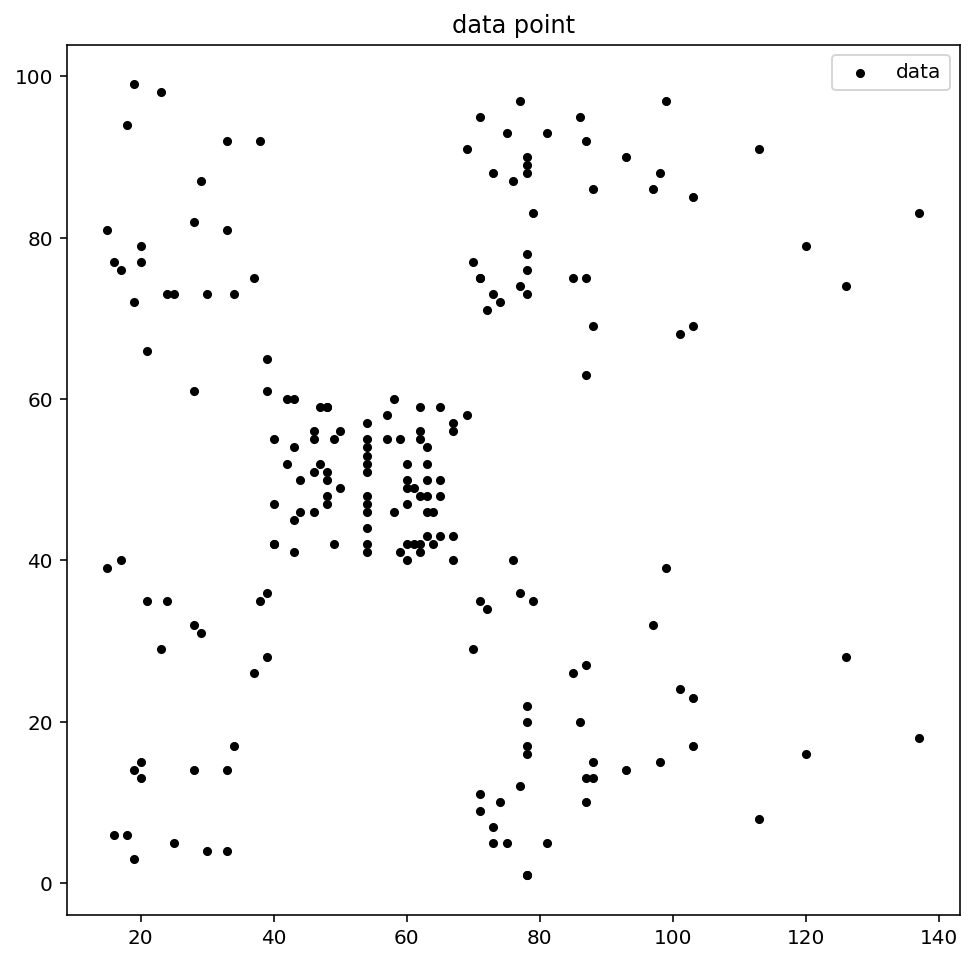

In [2]:
dataset = pd.read_csv('data-kmeans.csv')
data = dataset.values
plt.figure(1,figsize=(8,8))
plt.scatter(data[:,0], data[:,1], s=50, c="black", marker=".", label="data")
plt.title("data point")
plt.legend()
plt.show()

In [4]:
def compute_distance(a, b):
    #distance between a and b#
    # 원래 거리는 루트인데 제곱 했으니 **0.5 대신 **1
    dist = ((a[0] - b[0])**2 + (a[1] - b[1])**2)
    return dist

def compute_centroid(Z):
    # Z 집합에 있는 모든 점들의 평균
    #centroid of a set of points in P#
    x = 0
    y = 0
    n = Z.shape[0]
    for point in Z:
        x += point[0]
        y += point[1]
    x /= n
    y /= n
    center = np.array([x,y])
    return center

def compute_label(z, M):
    # M 이라는 중간 점 집합중 가장 가까운 z를 찾아 라벨 붙히기
    # M 은 중간점과 라벨이라는 값을 가지고 있음? 아님 배열에 들어가 있는 순서대로 할까?
    # 라벨은 M 집합에 들어 있는 순서대로 0~k 개 까지 있다고 하자
    #label of point z with a set of centroids M#
    distanceList = []
    for centroid in M:
        distanceList.append(compute_distance(centroid, z))
    minDistance = min(distanceList)
    label = distanceList.index(minDistance)
    return label

def compute_loss(C, M):
    # C 는 [[x,y,label], [x,y,label], .....] (200,3)
    # M 은 [[0클 중간좌표 x,y], [1클 x,y], ...] (k,2)
    # 로스값은 해당 클러스터에 들어있는 모든 점과 중점과의 거리를 모두 합해 평균낸 것
    #compute loss#
    loss = 0
    n = C.shape[0]
    for point in C:
        loss += compute_distance([point[0], point[1]], M[point[2]])
    return loss/n


## Initialize

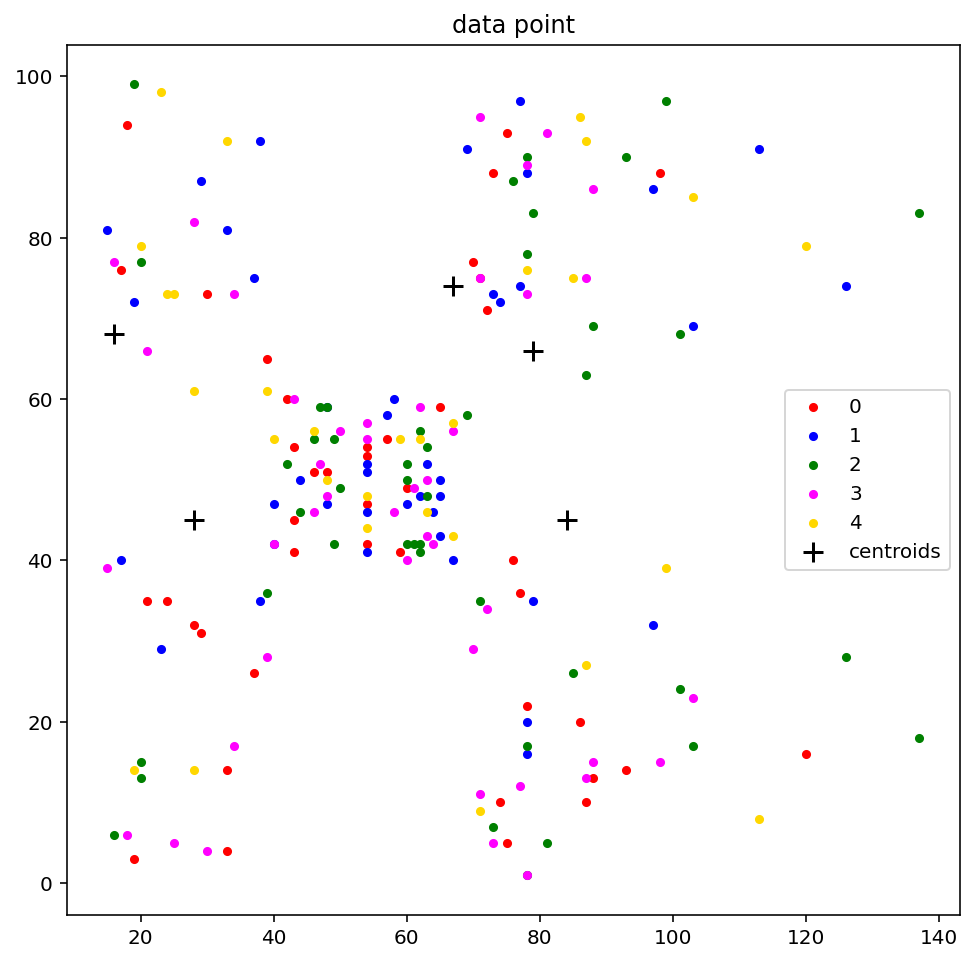

In [5]:
k = 5
n = data.shape[0]
color = ['red', 'blue', 'green', 'magenta', 'gold']
meanArray = np.random.randint(min(data[:,0]),max(data[:,1]),(k,2))
labelArray = np.random.randint(0,k,(n,1))
dataMatrix = np.hstack((data, labelArray))

plt.figure(1,figsize=(8,8))
for cluster in range(k):
  cIdx = (dataMatrix[:,2]==cluster)
  plt.scatter(dataMatrix[cIdx, 0], dataMatrix[cIdx, 1], s=50, c=color[cluster], marker=".", label=str(cluster))
plt.scatter(meanArray[:,0], meanArray[:,1], s=100, c='black', marker='+', label='centroids')
plt.title("data point")
plt.legend()
plt.show()

## k-means algorithm

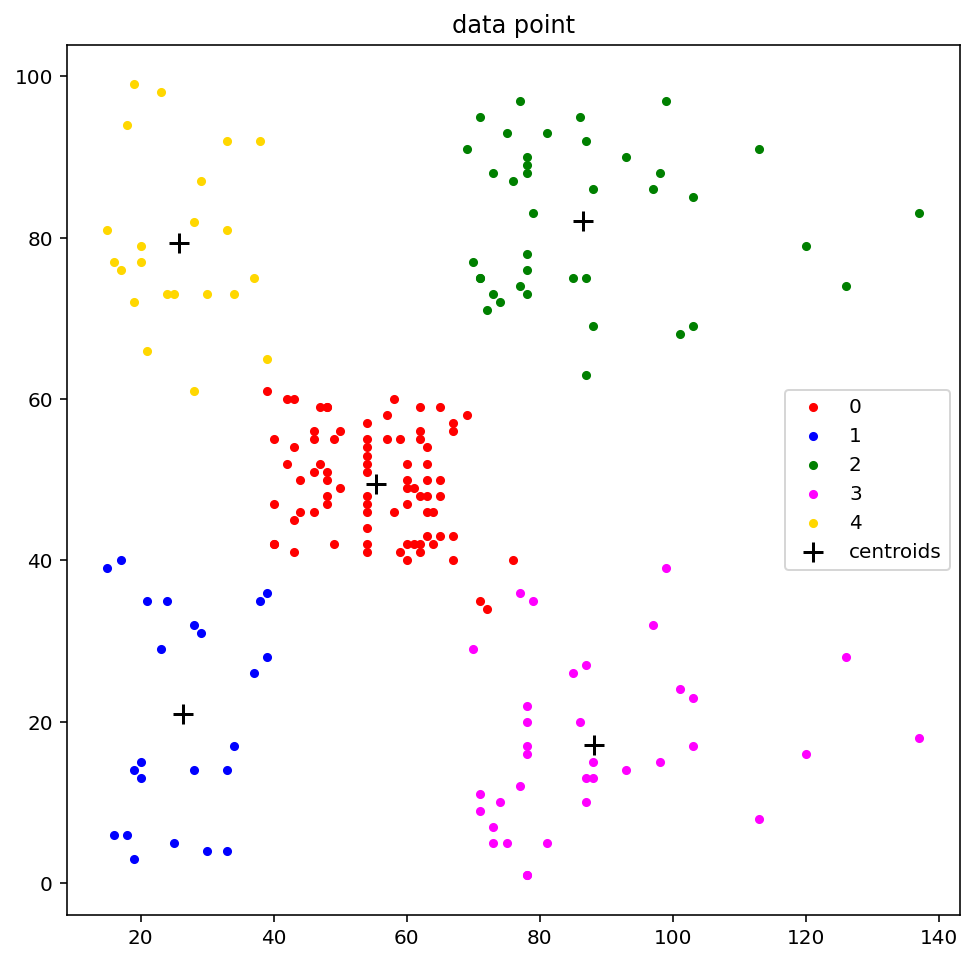

In [7]:
# data = [[x,y],[x,y], .....] 그냥 데이터 (200,2)
# labelArray = [[1],[3], .....] 데이터에 해당하는 클러스터 번호(라벨) (200,1)
# dataMatrix = [[x,y,label], [x,y,label], ..... ] 각 데이터의 좌표와 클러스터 번호(라벨) (200,3)
# meanArray =  [[x,y], [x,y], ..... ] 각 클러스터의 중앙값 (k,2)

# 정상 라벨 할당

iter = 20
lossList = np.zeros((iter,1))
CList = np.zeros((iter,k))

for iteration in range(iter):
  for idx in range(len(data)):
    labelArray[idx][0] =  compute_label(data[idx],meanArray)
  dataMatrix = np.hstack((data, labelArray))

  meanArray = np.zeros((k,2))
  for cluster in range(k):
    clusterIdx = (dataMatrix[:,2]==cluster)
    meanArray[cluster] = compute_centroid(data[clusterIdx])
  # loss 계산 하여 저장하기
  lossList[iteration] = (compute_loss(dataMatrix, meanArray))**0.5
  # 원점과 중앙값의 거리를 array에 저장
  distanceCentroid = [] # [0번클 거리, 1번클 거리, ... k-1번클 거리] (1,k)
  for cluster in range(k):
    distanceCentroid.append((compute_distance(meanArray[cluster], np.zeros((2))))**0.5)
  CList[iteration] = distanceCentroid

plt.figure(1,figsize=(8,8))
for cluster in range(k):
  cIdx = (dataMatrix[:,2]==cluster)
  plt.scatter(dataMatrix[cIdx, 0], dataMatrix[cIdx, 1], s=50, c=color[cluster], marker=".", label=str(cluster))
plt.scatter(meanArray[:,0], meanArray[:,1], s=100, c='black', marker='+', label='centroids')
plt.title("data point")
plt.legend()
plt.show()

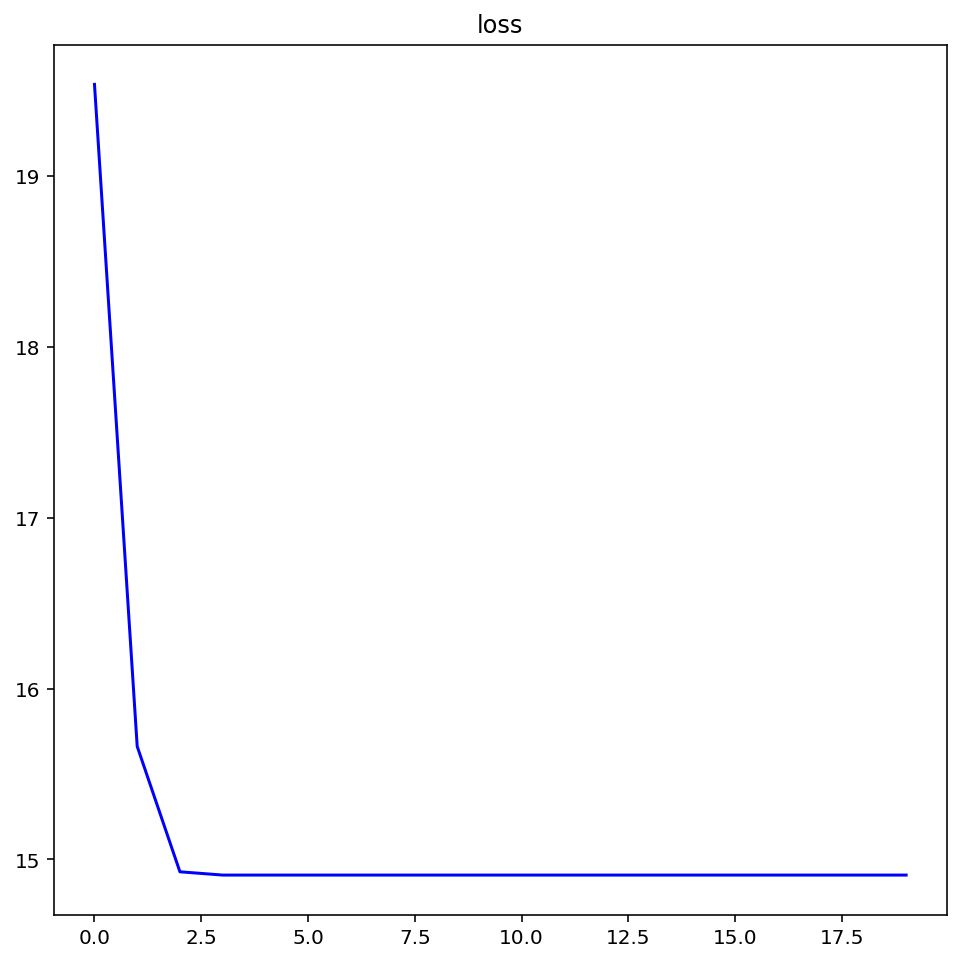

In [55]:
plt.figure(1,figsize=(8,8))
plt.plot(range(iter), lossList, color='blue')
plt.title("loss")
plt.show()

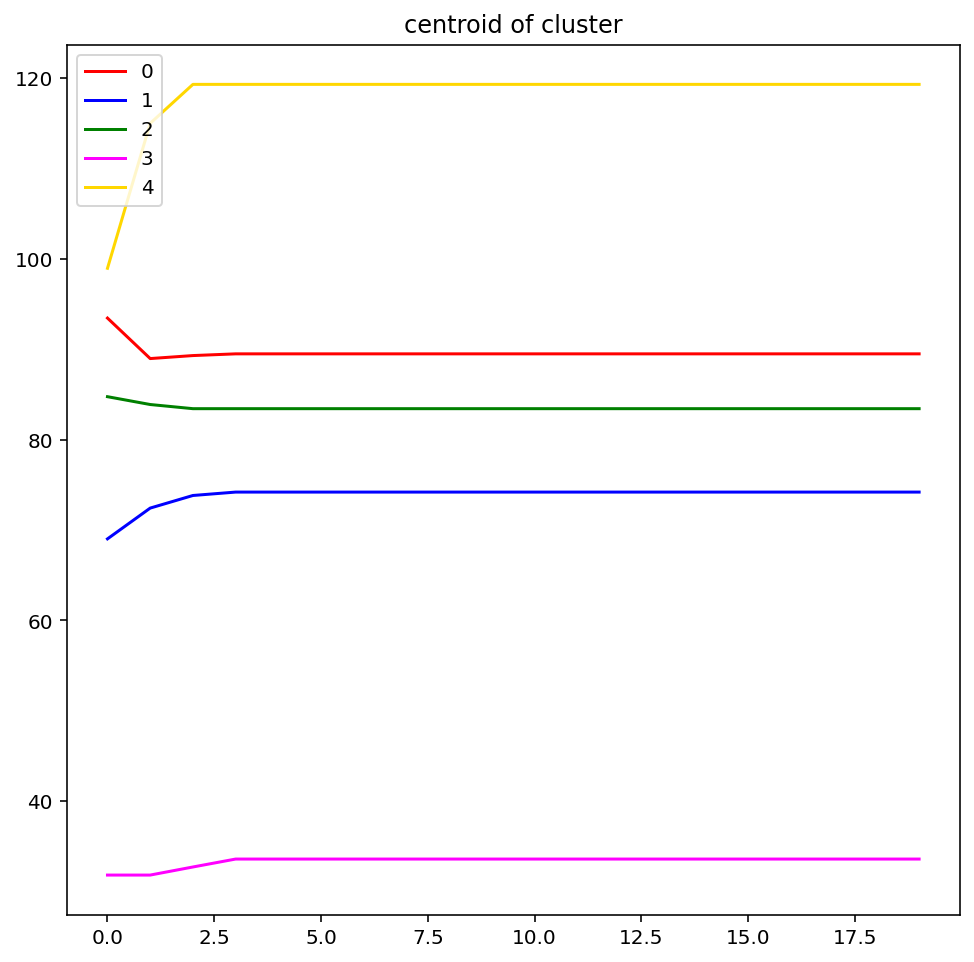

In [58]:
plt.figure(1,figsize=(8,8))
CListT = CList.T
for cluster in range(k):
  plt.plot(range(iter), CListT[cluster], color=color[cluster], label=str(cluster))
plt.legend()
plt.title("centroid of cluster")
plt.show()

## output
1. plot the data points

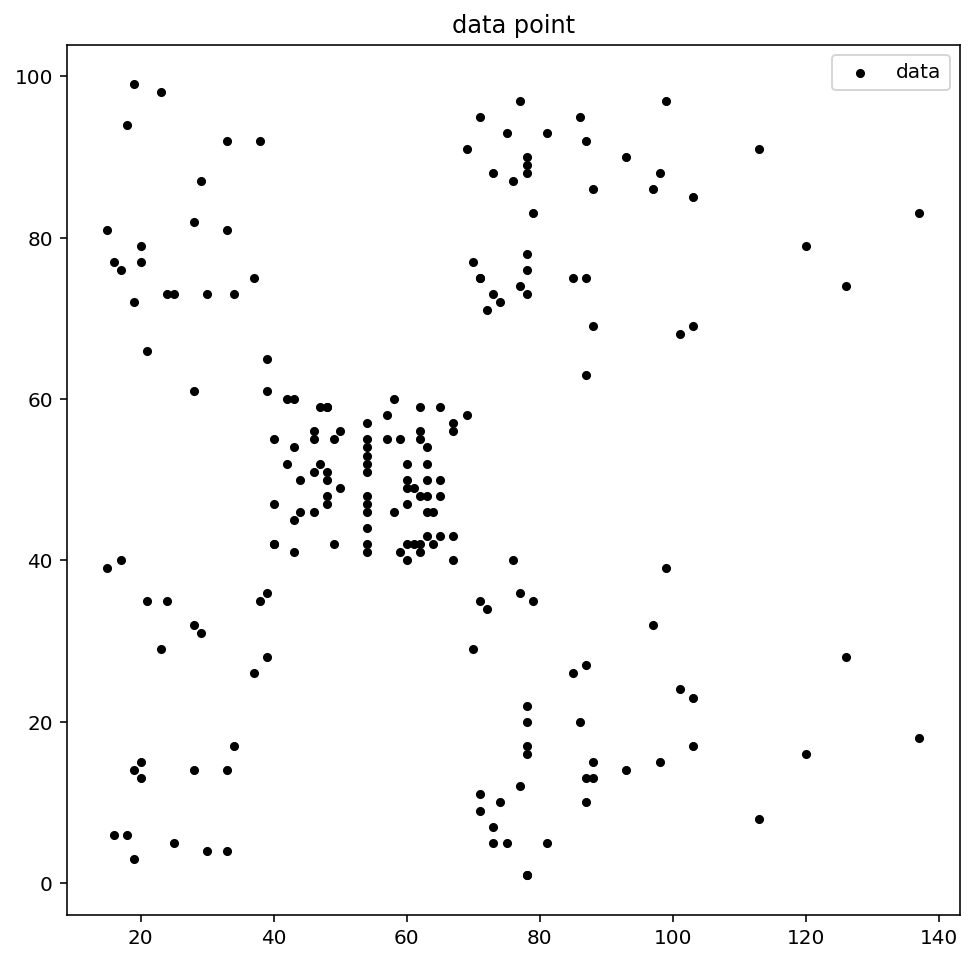

In [3]:
plt.figure(1,figsize=(8,8))
plt.scatter(data[:,0], data[:,1], s=50, c="black", marker=".", label="data")
plt.title("data point")
plt.legend()
plt.show()

2. Visualise the initial condition of the point labels

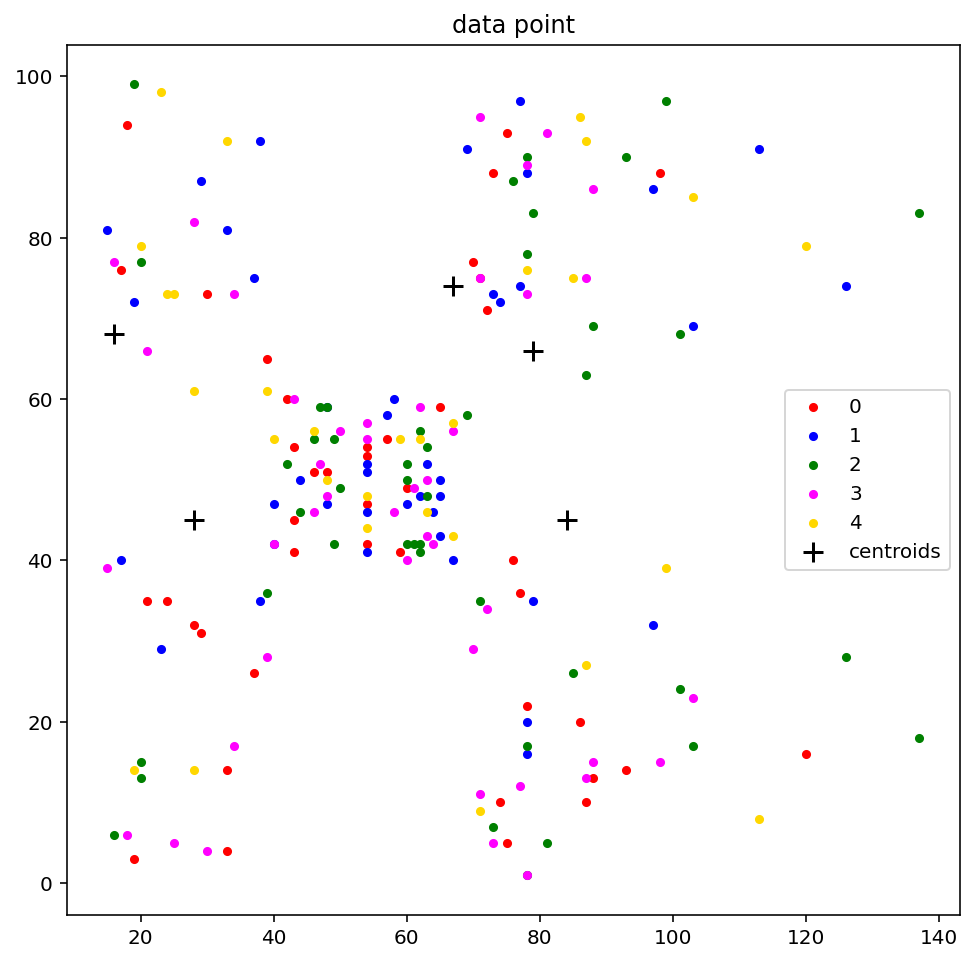

In [6]:
plt.figure(1,figsize=(8,8))
for cluster in range(k):
  cIdx = (dataMatrix[:,2]==cluster)
  plt.scatter(dataMatrix[cIdx, 0], dataMatrix[cIdx, 1], s=50, c=color[cluster], marker=".", label=str(cluster))
plt.scatter(meanArray[:,0], meanArray[:,1], s=100, c='black', marker='+', label='centroids')
plt.title("data point")
plt.legend()
plt.show()

3. Plot the loss curve

In [ ]:
plt.figure(1,figsize=(8,8))
plt.plot(range(iter), lossList, color='blue')
plt.title("loss")
plt.show()

4. Plot the centroid of each clsuter

In [ ]:
plt.figure(1,figsize=(8,8))
CListT = CList.T
for cluster in range(k):
  plt.plot(range(iter), CListT[cluster], color=color[cluster], label=str(cluster))
plt.legend()
plt.title("centroid of cluster")
plt.show()

5. Plot the final clustering result

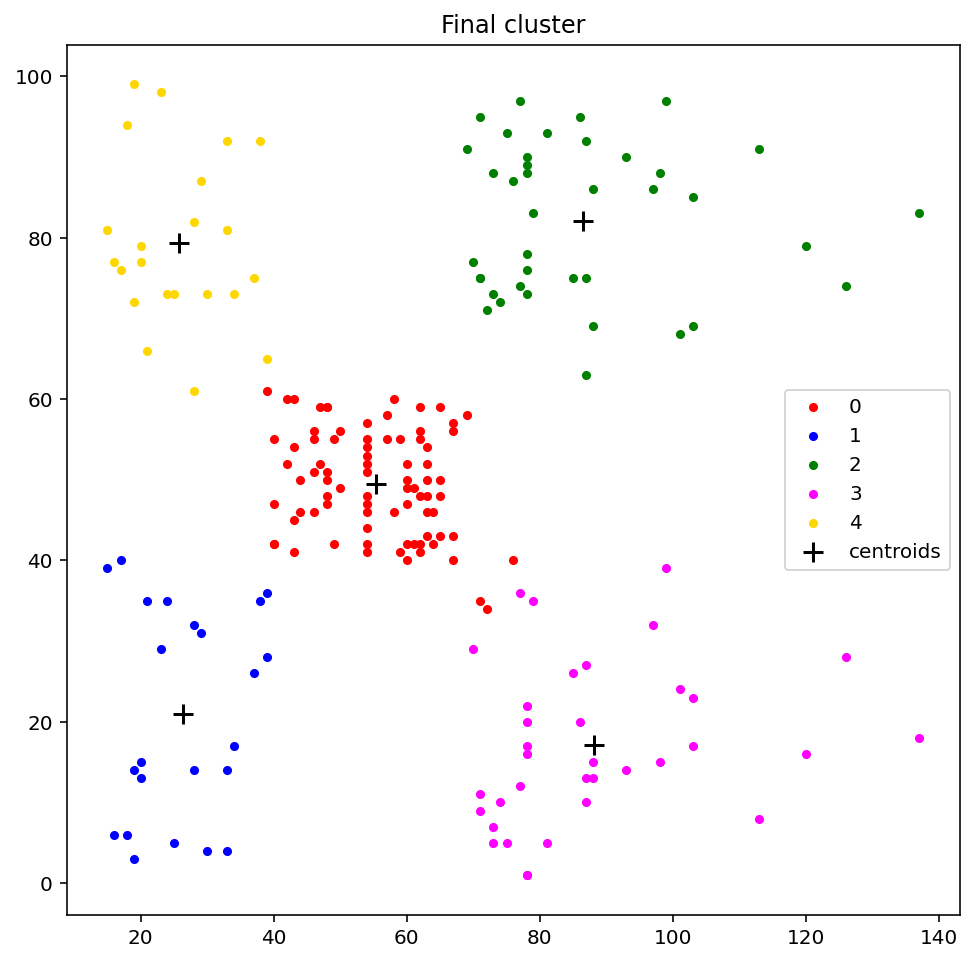

In [8]:
plt.figure(1,figsize=(8,8))
for cluster in range(k):
  cIdx = (dataMatrix[:,2]==cluster)
  plt.scatter(dataMatrix[cIdx, 0], dataMatrix[cIdx, 1], s=50, c=color[cluster], marker=".", label=str(cluster))
plt.scatter(meanArray[:,0], meanArray[:,1], s=100, c='black', marker='+', label='centroids')
plt.title("Final cluster")
plt.legend()
plt.show()